In [6]:
#loading the required packages
pacman::p_load(lattice, chron, grid, xts, syuzhet, lubridate, scales, reshape2, wordcloud, stm, quanteda, stringr, qdap, plotly,tidyr, tm, graph, readr, Rgraphviz, lsa, scatterplot3d, SnowballC, ldatuning, LearnBayes, topicmodels, ggplot2, tidytext,dplyr,igraph, visNetwork, RWeka, devtools, httr, forecast) 


In [11]:
tweets <- read.csv("E:/ASU Energy Leadership Informatics/Data/orovilledam.csv")

In [51]:
filter <- str_replace_all(tweets$Tweet, "@\\w+", "")

In [52]:
#Applying cleaning functions to the tweets
wordCorpus <- Corpus(VectorSource(filter))
wordCorpus <- tm_map(wordCorpus, removePunctuation)
wordCorpus <- tm_map(wordCorpus, content_transformer(tolower))
wordCorpus <- tm_map(wordCorpus, removeWords, stopwords("english"))
wordCorpus <- tm_map(wordCorpus, removeWords, c("orovilledam","rt","california","trump","trumps","amp","oroville","infrastructure","people","water","dam",
                                          "sanctuarycitylvnancy","evacuated","evacuate","money","emergency","food","shelter","fakenewsapprovesaid","fakenews",
                                          "requestjerrybrowngov", "wcafixkamalaharriscarrieksada", "realdonaldtrump","investigating","offeringopenyuba","jerrybrowngov",
                                          "spillway","evacu", "orovillespillway", "liber","illeg","gov","fakenew", "situation", "brownnow","will" ,"templ", "sikh",
                                          "htt", "chanc","pleas", "updat","evacuation","temples"))
wordCorpus <- tm_map(wordCorpus, stripWhitespace)

In [53]:
orv_corpus <- wordCorpus

In [54]:
orv_corpus = gsub("&amp", "", orv_corpus)
orv_corpus = gsub("(RT|via)((?:\\b\\W*@\\w+)+)", "", orv_corpus)
orv_corpus = gsub("@\\w+", "", orv_corpus)
orv_corpus = gsub("[[:punct:]]", "", orv_corpus)
orv_corpus = gsub("[[:digit:]]", "", orv_corpus)
orv_corpus = gsub("http\\w+", "", orv_corpus)
orv_corpus = gsub("[ \t]{2,}", "", orv_corpus)
orv_corpus = gsub("^\\s+|\\s+$", "", orv_corpus) 

In [60]:
writeLines(as.character(orv_corpus), con="E:/ASU Energy Leadership Informatics/Data/orvcorpus.txt")

In [85]:
orv_corpus <- file.path("E:/ASU Energy Leadership Informatics/Data/","test")
orv_corpus <- Corpus(DirSource(orv_corpus))
#creating a document term matrix from the corpus
orv_dtm <- DocumentTermMatrix(orv_corpus)

In [86]:
#creating a matrix 
orv_m <- as.matrix(orv_dtm)

In [87]:
#finding sum of words in each document
rowtotals <- apply(orv_dtm, 1, sum)

In [88]:
#removing documents without words, i.e., empty documents
orv_dtm <- orv_dtm[rowtotals> 0,]

# Topic Modeling 

In [66]:
#Performing Gibbs Resampling to compute the optimum number of topics
k <- FindTopicsNumber(orv_dtm, topics=seq(from=2, to=20, by=2), metrics=c("Griffiths2004"), 
                      method="Gibbs", control=list(seed=35), mc.cores=4L, verbose= TRUE)

fit models... done.
calculate metrics:
  Griffiths2004... done.


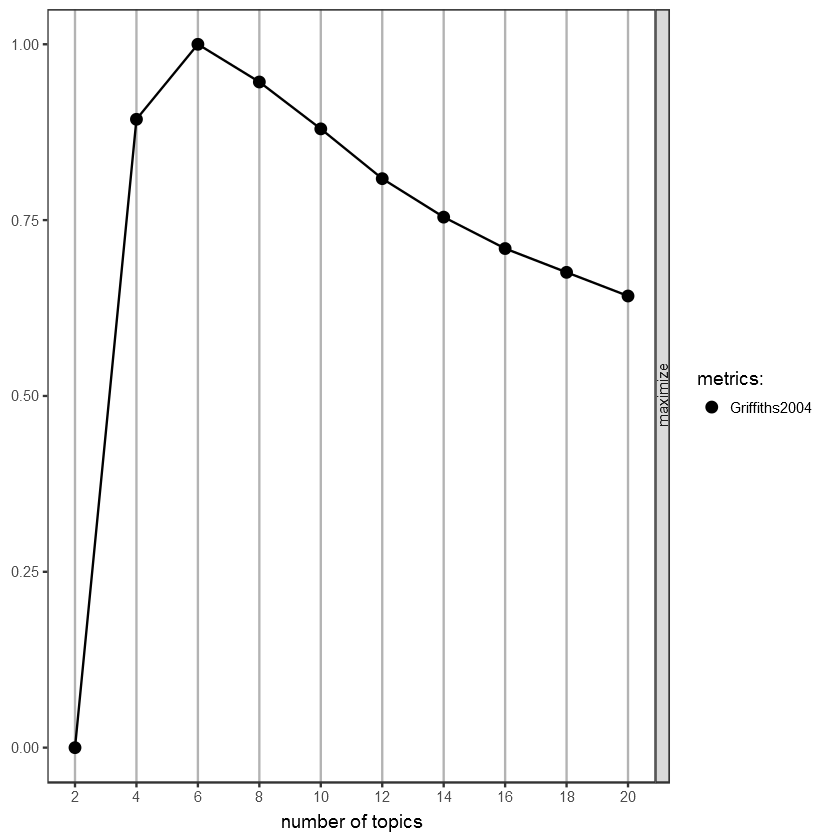

In [67]:
#Plotting the likelihood function to determine number of topics
FindTopicsNumber_plot(k)

In [89]:
#performing Latent Dirichlet Allocation to carry out Topic Modeling
orv_lda <- LDA(orv_dtm, k = 6, control = list(seed = 1234))

In [94]:
#calculating posterior probability on the lda model
postlist <- posterior(orv_lda)

In [95]:
# postlist$topics will produce the doc-topic matrix, which you can create as data.frame
doc.topics <- data.frame(postlist$topics)


In [96]:
# postlist$terms will produce the word-topic matrix; use transpose to get word x topic
word.topics <- data.frame(t(postlist$terms))
num.col <- ncol(word.topics)

In [97]:
# initialize topic.names vector
topic.names <- character(length=num.col)

In [98]:
# create topic names using first five words
for (i in 1:num.col){
  top.words <- rownames(word.topics[order(word.topics[,i], decreasing = T),])
  topic.names[i] <- paste(top.words[1:5], collapse = " + ")
}

In [99]:
# renaming topics
colnames(word.topics) <- c(topic.names)
colnames(doc.topics) <- c(topic.names)

In [100]:
#setting a threshold for the correlation between topics
cor_threshold <- .3

In [101]:
cor_mat <- cor(word.topics[,2:num.col])
cor_mat[ cor_mat < cor_threshold ] <- 0
diag(cor_mat) <- 0

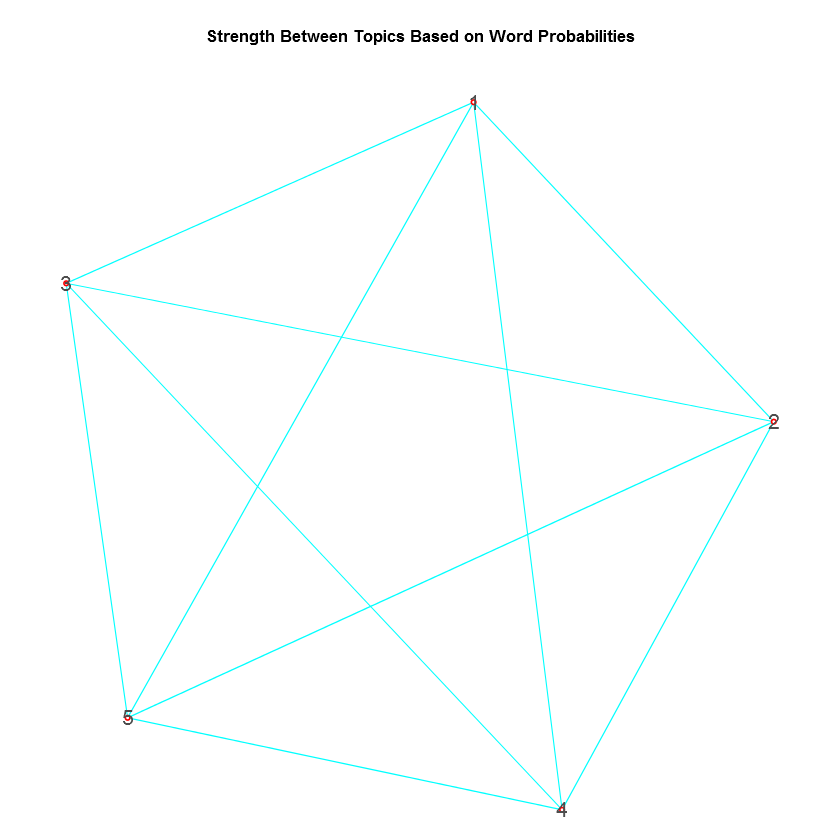

In [102]:
library(igraph)

graph <- graph.adjacency(cor_mat, weighted=TRUE, mode="lower")

E(graph)$edge.width <- E(graph)$weight
V(graph)$label <- paste(1:5)

par(mar=c(0, 0, 3, 0))
set.seed(123)
plot.igraph(graph, edge.width = E(graph)$edge.width, 
            edge.color = "cyan", vertex.color = "white", vertex.size = 1,
            vertex.frame.color = "red", vertex.label.color = "grey30")
title("Strength Between Topics Based on Word Probabilities", cex.main=.8)


[1] "communities"

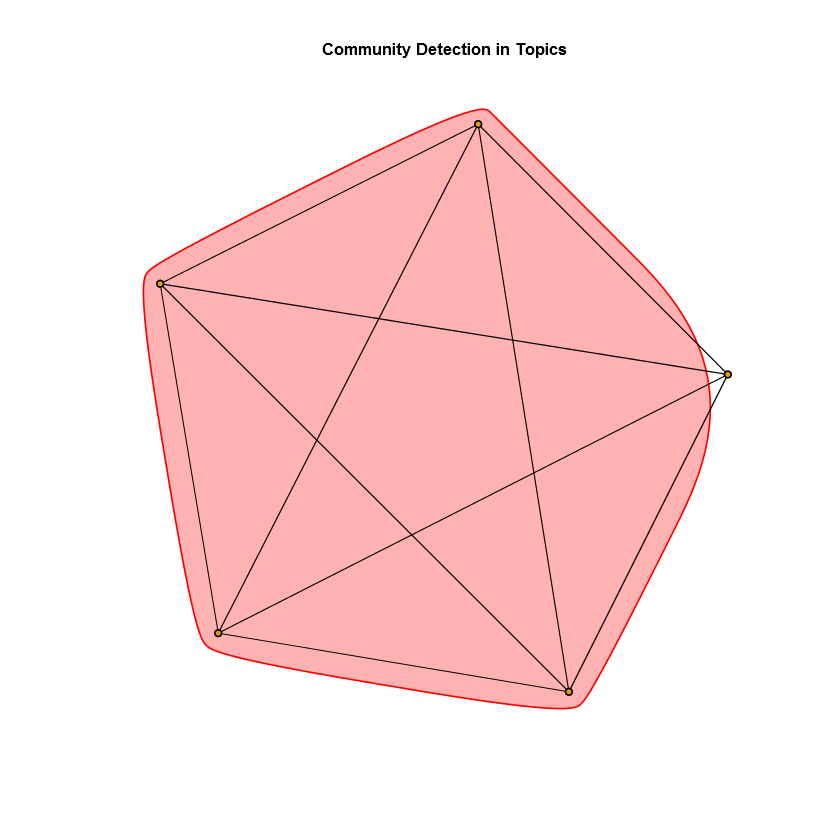

In [103]:
#Community Detection among the topics
clp <- cluster_label_prop(graph)
class(clp)

plot(clp, graph, edge.width = E(graph)$edge.width, vertex.size = 2, vertex.label = "")
title("Community Detection in Topics", cex.main=.8)

V(graph)$community <- clp$membership
V(graph)$betweenness <- betweenness(graph, v = V(graph), directed = F)
V(graph)$degree <- degree(graph, v = V(graph))

In [104]:
#Checking the top 15 terms in each topic, to assign topic names
terms(orv_lda,15)

Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6
"'evacuation',","'thanks',","'people',","'thanks',","'people',","'people',"
"'news',","'evacuation',","'evacuation',","'water',","'trump',","'evacuation',"
"'trump',","'need',","'evacuees',","'evacuation',","'water',","'water',"
"'like',","'daily',","'rain',","'like',","'help',","'infrastructure',"
"'daily',","'water',","'infrastructure',","'could',","'news',","'evacuees',"
"'dams',","'still',","'still',","'crisis',","'situation',","'daily',"
"'state',","'live',","'help',","'rain',","'evacuees',","'news',"
"'live',","'people',","'daily',","'brown',","'order',","'time',"
"'thanks',","'area',","'water',","'state',","'still',","'lake',"
"'home',","'trump',","'lake',","'illegals',",'evacuees'],"'state',"


In [105]:
readr::write_csv(tidy(orv_lda, "beta"), "beta.csv")

readr::write_csv(tidy(orv_lda, "gamma"), "gamma.csv")

In [106]:
#checking if the document term matrix contains any sparse terms
orv_dtm

<<DocumentTermMatrix (documents: 1, terms: 14642)>>
Non-/sparse entries: 14642/0
Sparsity           : 0%
Maximal term length: 36
Weighting          : term frequency (tf)

In [107]:
#extracting probability of each word per topic
orv_topics <- tidy(orv_lda, matrix="beta")

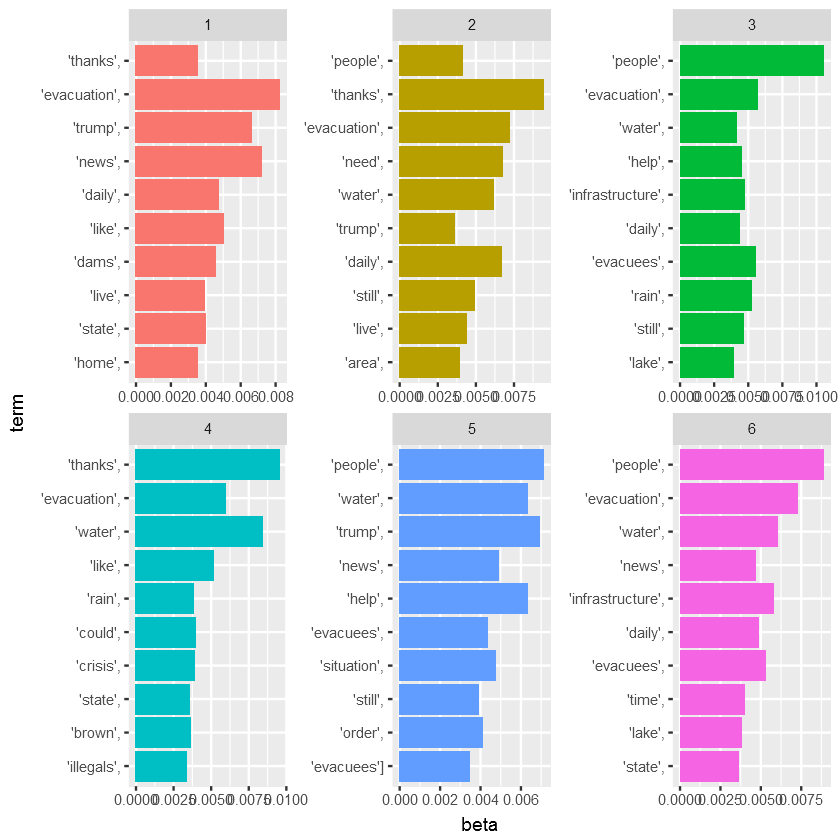

In [108]:
orv_top_terms <- orv_topics %>%
  group_by(topic) %>%
  top_n(10, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)

orv_top_terms %>%
  mutate(term = reorder(term, beta)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  coord_flip()

In [109]:
beta_spread <- orv_topics %>%
  mutate(topic = paste0("topic", topic)) %>%
  top_n(30, beta) %>%  
spread(topic, beta) %>%
    filter(topic1 > .00001 | topic2 > .00001) %>%
  mutate(log_ratio = log2(topic2 / topic1))
beta_spread

term,topic1,topic2,topic3,topic4,topic5,topic6,log_ratio
"'daily',",0.004717847,0.006679565,NA,NA,NA,0.004832234,0.5016257
"'evacuation',",0.008231246,0.007177326,0.005648358,0.005952579,NA,0.007288934,-0.1976643
"'like',",0.005012272,NA,NA,0.005166832,NA,NA,NA
"'need',",NA,0.006750360,NA,NA,NA,NA,NA
"'news',",0.007201182,NA,NA,NA,0.004897598,NA,NA
"'still',",NA,0.004925081,NA,NA,NA,NA,NA
"'thanks',",NA,0.009423781,NA,0.009553276,NA,NA,NA
"'trump',",0.006639427,NA,NA,NA,0.006908432,NA,NA
"'water',",NA,0.006131558,NA,0.008389549,0.006308736,0.006055480,NA


# Performing a Sentiment Analysis on the Tweets

### The  NRC Word-Emotion Association Lexicon is used in this algorithm. The lexicon contains words with associated scores for eight different emotions and two sentiments (positive/negative). Each individual word in the lexicon will have a “yes” (one) or “no” (zero) for the emotions and sentiments, and we can calculate the total sentiment of a sentence by adding up the individual sentiments for each word in the sentence.

In [31]:
mySentiment <- get_nrc_sentiment(as.character(tweets$Tweet))

In [4]:
head(mySentiment)

anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,1,0
0,1,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,1,0
0,0,0,1,0,1,1,0,1,0


In [5]:
tweets <- cbind(tweets, mySentiment)

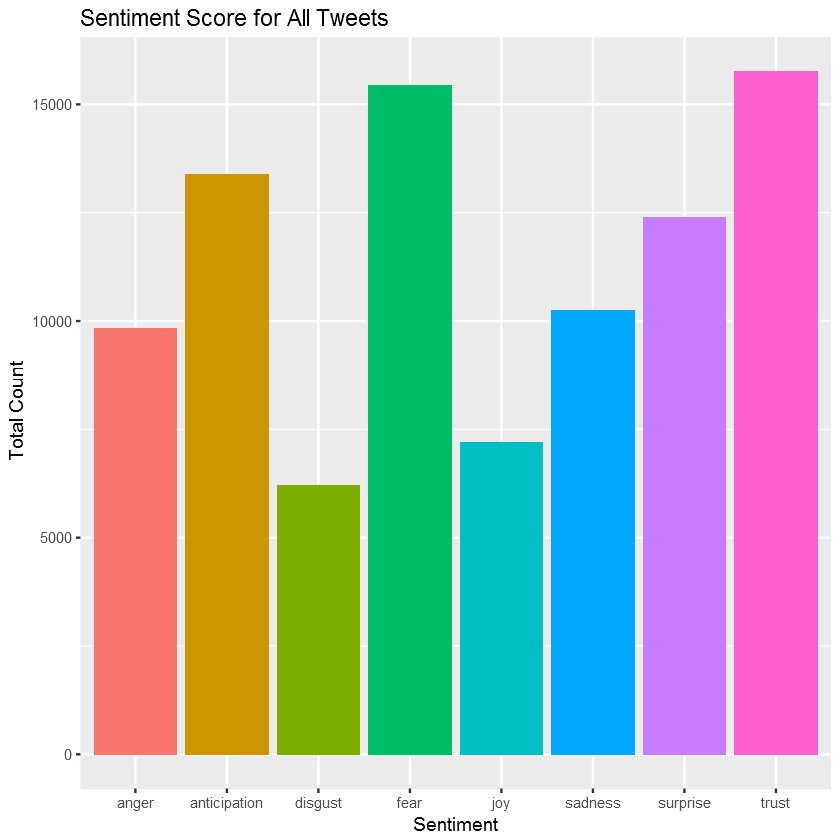

In [6]:
#Plotting the emotion distribution for all the tweets
sentimentTotals <- data.frame(colSums(tweets[,c(51:58)]))
names(sentimentTotals) <- "count"
sentimentTotals <- cbind("sentiment" = rownames(sentimentTotals), sentimentTotals)
rownames(sentimentTotals) <- NULL
ggplot(data = sentimentTotals, aes(x = sentiment, y = count)) +
        geom_bar(aes(fill = sentiment), stat = "identity") +
        theme(legend.position = "none") +
        xlab("Sentiment") + ylab("Total Count") + ggtitle("Sentiment Score for All Tweets")

## Time-Series Plots of Tweets 

In [19]:
tweets$timestamp <- as.character(tweets$timestamp)
typeof(tweets$timestamp)
head(tweets$timestamp)

[1] "character"

[1] "2017-02-03-00-56-00" "2017-02-08-15-13-00" "2017-02-08-23-20-00"
[4] "2017-02-09-03-22-00" "2017-02-09-16-06-00" "2017-02-09-18-55-00"

In [20]:
tweets$timestamp <- parse_date_time(tweets$timestamp,orders="ymd HMS")

In [9]:
tweets$weekday <- wday(tweets$timestamp, label = TRUE)

In [10]:
weeklysentiment <- tweets %>% group_by(weekday) %>% 
        summarise( 
                  anticipation = mean(anticipation), 
                  disgust = mean(disgust), 
                  fear = mean(fear), 
                  joy = mean(joy), 
                  sadness = mean(sadness), 
                  surprise = mean(surprise), 
                  trust = mean(trust)) %>% melt

Using weekday as id variables


In [11]:
names(weeklysentiment) <- c("weekday", "sentiment", "meanvalue")

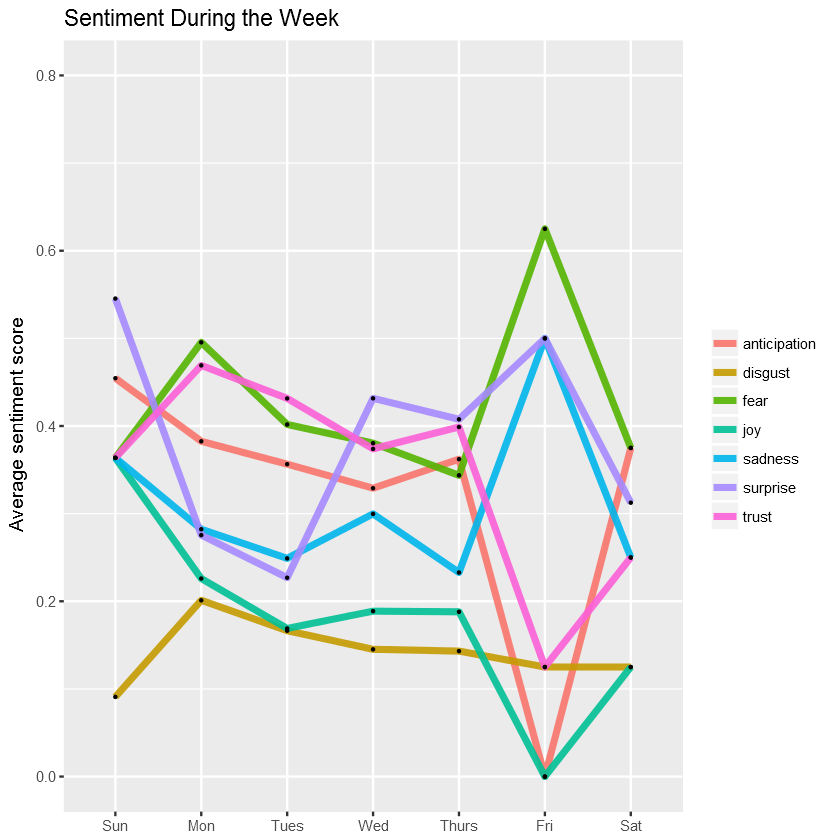

In [12]:
ggplot(data = weeklysentiment, aes(x = weekday, y = meanvalue, group = sentiment)) +
        geom_line(size = 1.5, alpha = 0.9, aes(color = sentiment)) +
        geom_point(size = 0.2) +
        ylim(0, 0.8) +
        theme(legend.title=element_blank(), axis.title.x = element_blank()) +
        ylab("Average sentiment score") + 
        ggtitle("Sentiment During the Week")

In [13]:
t <- (tweets$Tweet)
typeof(t)

[1] "integer"

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


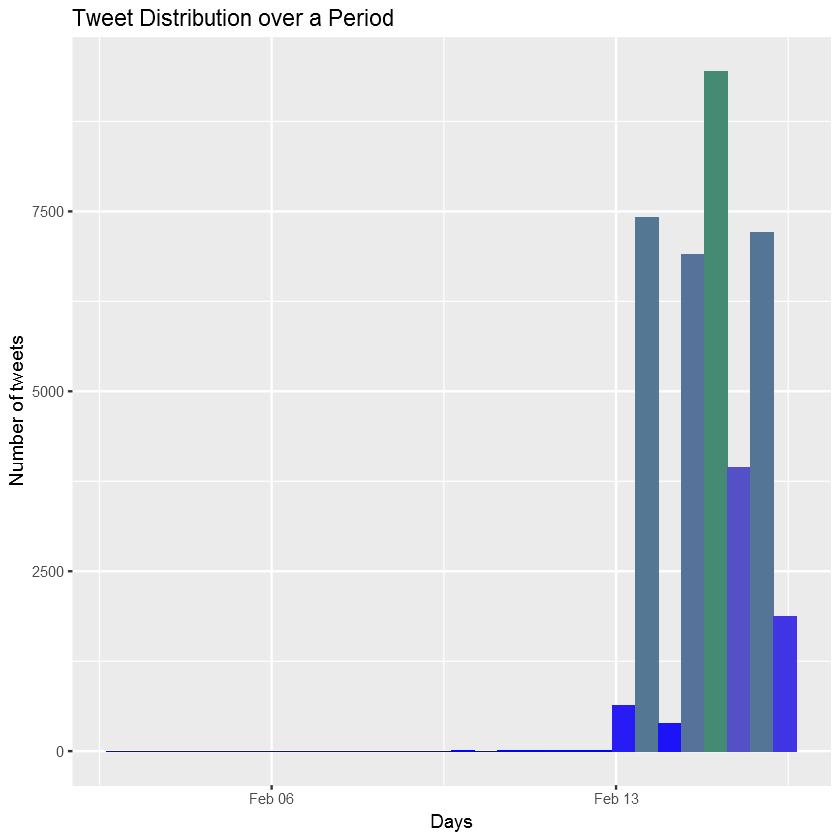

In [14]:
ggplot(data = tweets, aes(x = timestamp)) +
        geom_histogram(aes(fill = ..count..)) +
        theme(legend.position = "none") +
        xlab("Days") + ylab("Number of tweets") + 
        scale_fill_gradient(low = "blue", high = "aquamarine4")+
        ggtitle("Tweet Distribution over a Period")

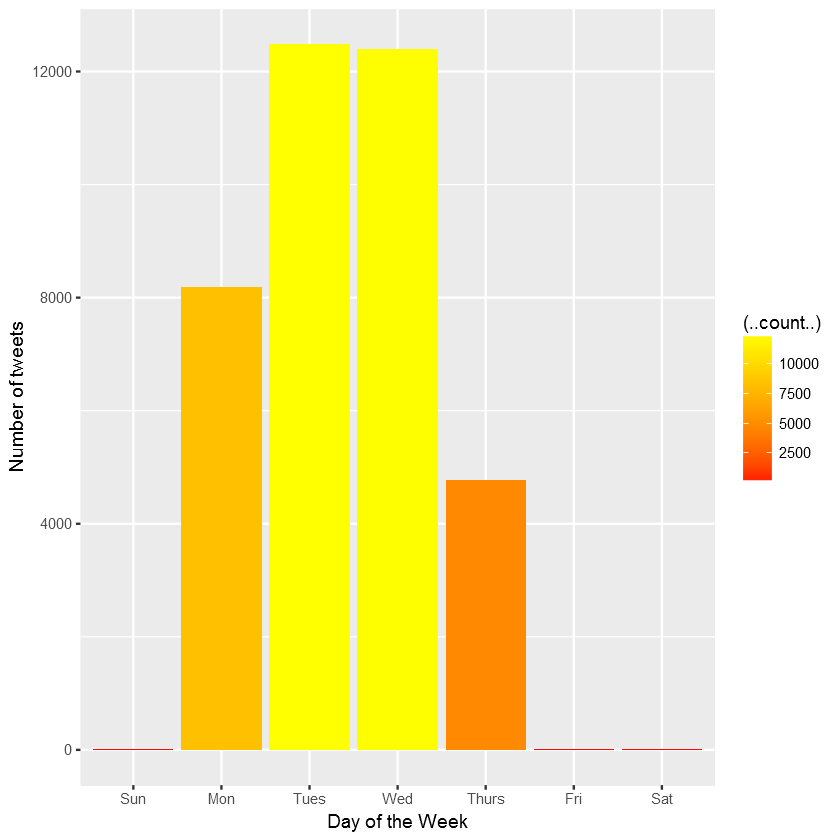

In [41]:
ggplot(tweets,aes(wday(x=timestamp, label=TRUE)))+
geom_bar(aes(fill = (..count..)))+ 
xlab("Day of the Week")+ 
ylab("Number of tweets") +
scale_fill_gradient(low = "red", high = "yellow") 


## Hypotheses Testing 

### Chi-Square Hypotheses tests are conducted to see if the distribution of tweets over the week tends to be uniform or non-uniform.
Null Hypothesis: People tweet at the same rate on all the days of the week.
Aternate Hypothesis: People tweet at different rates on different days of the week

### A specific statement or hypothesis is generated about a population parameter, and sample statistics are used to assess the likelihood that the hypothesis is true.

In [16]:
chisq.test(table(wday(tweets$timestamp, label = TRUE)))



	Chi-squared test for given probabilities

data:  table(wday(tweets$timestamp, label = TRUE))
X-squared = 35913, df = 6, p-value < 2.2e-16


### Assuming a Confidence Interval of 95%, the p-value is less than 0.05, thus resulting in a rejection of the Null-Hypothesis that tweet distribution is same on all the days of the week. The bar graph above indicates that people tend to tweet more often, Monday through Thursday, than the weekends.

In [17]:
tweets$timeonly <- as.numeric(tweets$timestamp - trunc(tweets$timestamp, "days"))


In [18]:
#Checking if any of the times in the dataset are missing/not meaningful
tweets[(minute(tweets$timestamp) == 0 & second(tweets$timestamp) == 0),11] <- NA
mean(is.na(tweets$timeonly))

[1] 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


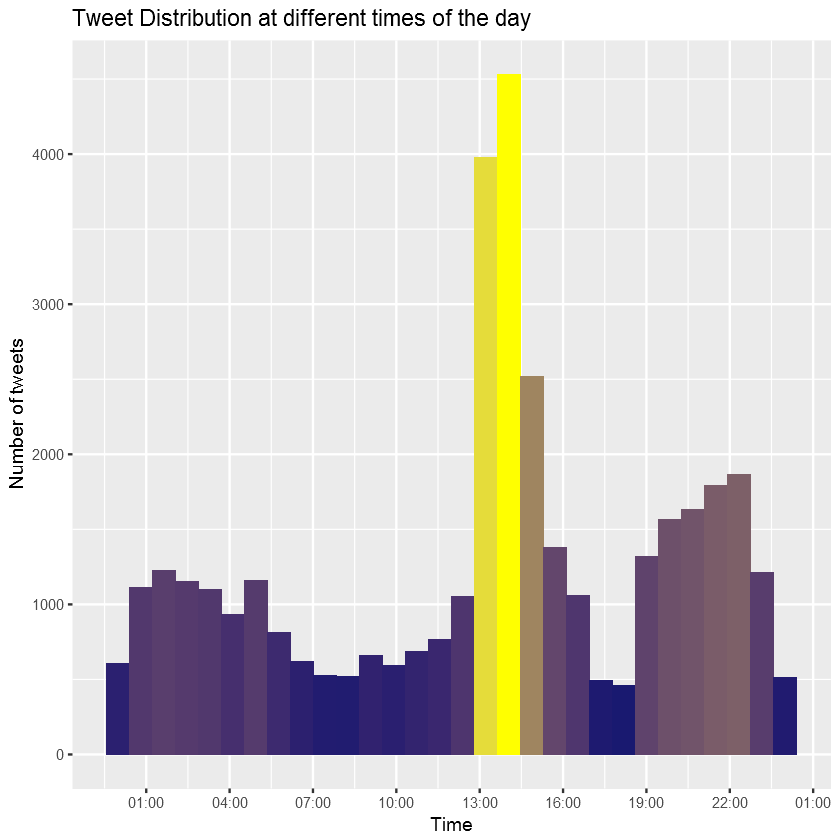

In [19]:
class(tweets$timeonly) <- "POSIXct"
ggplot(data = tweets, aes(x = timeonly)) +
        geom_histogram(aes(fill = ..count..)) +
        theme(legend.position = "none") +
        xlab("Time") + ylab("Number of tweets") + 
        scale_x_datetime(breaks = date_breaks("3 hours"), 
                         labels = date_format("%H:00")) +
        scale_fill_gradient(low = "midnightblue", high = "yellow")+
        ggtitle("Tweet Distribution at different times of the day")

In [42]:
#Importing the file containing hashtag details
test <- readLines("E:/ASU Energy Leadership Informatics/Data/test/test.txt")


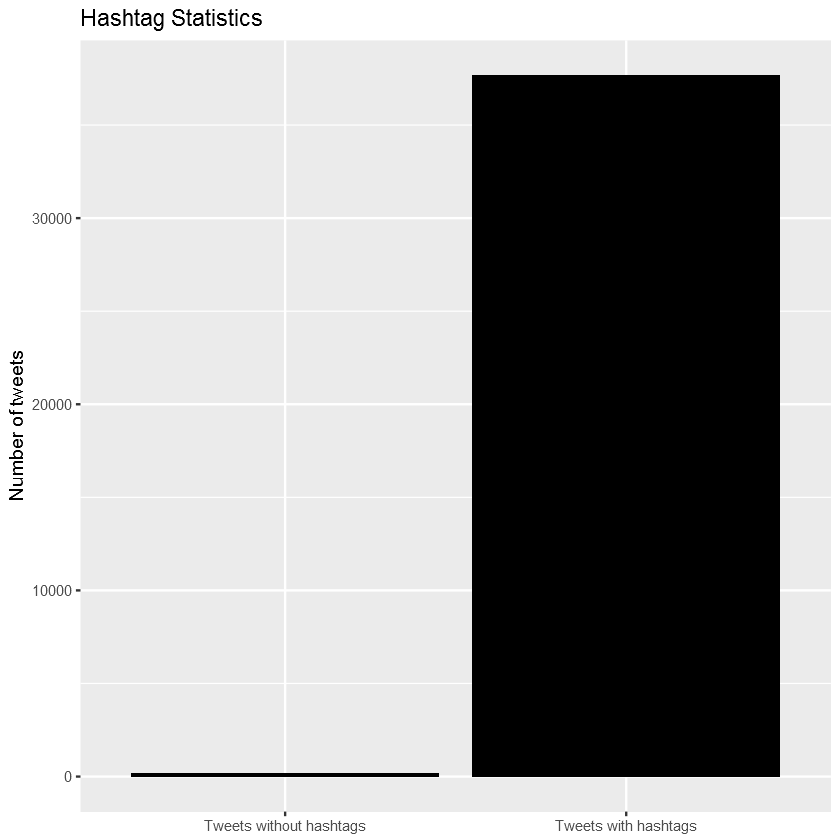

In [21]:
ggplot(tweets, aes(factor(grepl("#", Tweet)))) +
        geom_bar(fill = "black") + 
        theme(legend.position="none", axis.title.x = element_blank()) +
        ylab("Number of tweets") + 
        ggtitle("Hashtag Statistics") +
        scale_x_discrete(labels=c("Tweets without hashtags", "Tweets with hashtags"))

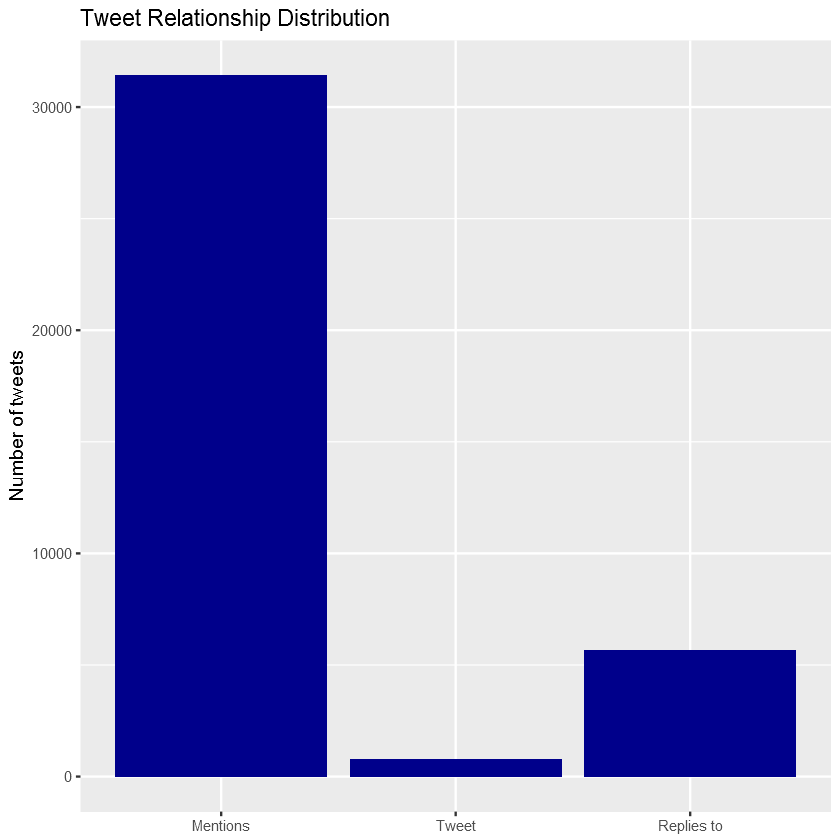

In [22]:
ggplot(tweets, aes(factor((Relationship)))) +
        geom_bar(fill = "darkblue") + 
        theme(legend.position="none", axis.title.x = element_blank()) +
        ylab("Number of tweets") + 
        ggtitle("Tweet Relationship Distribution") +
        scale_x_discrete(labels=c("Mentions", "Tweet", "Replies to"))

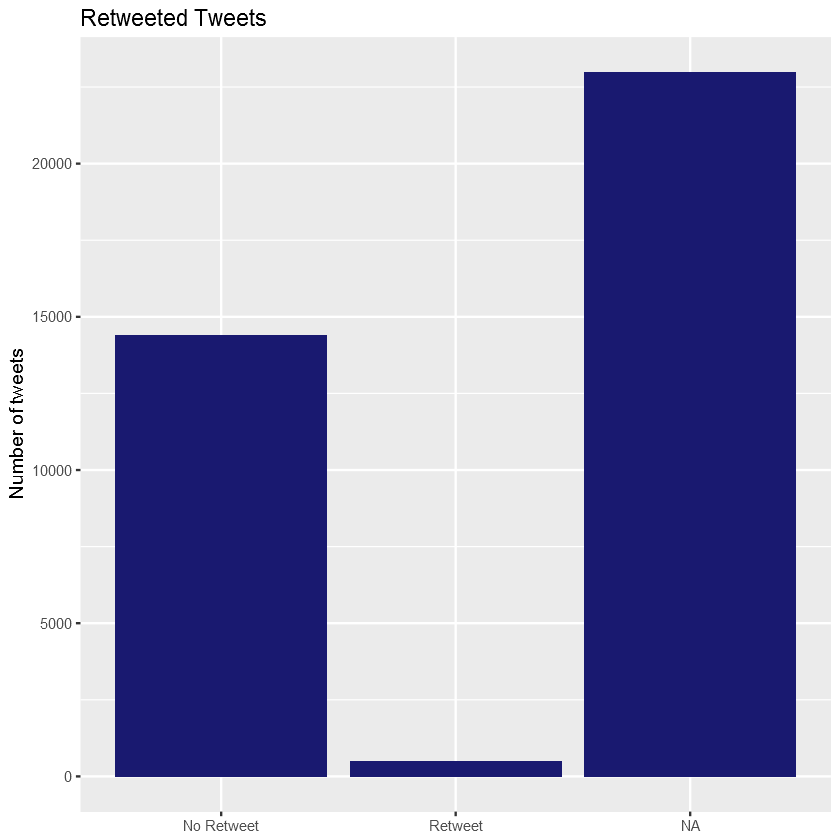

In [23]:
ggplot(tweets, aes(factor((Imported_Tweet_Type)))) +
        geom_bar(fill = "midnightblue") + 
        theme(legend.position="none", axis.title.x = element_blank()) +
        ylab("Number of tweets") + 
        ggtitle("Retweeted Tweets") +
        scale_x_discrete(labels=c("No Retweet", "Retweet"))

In [24]:
#Extracting usernames from tweets
users <- str_extract_all(tweets$Tweet, "@\\w+")
namesCorpus <- Corpus(VectorSource(users))

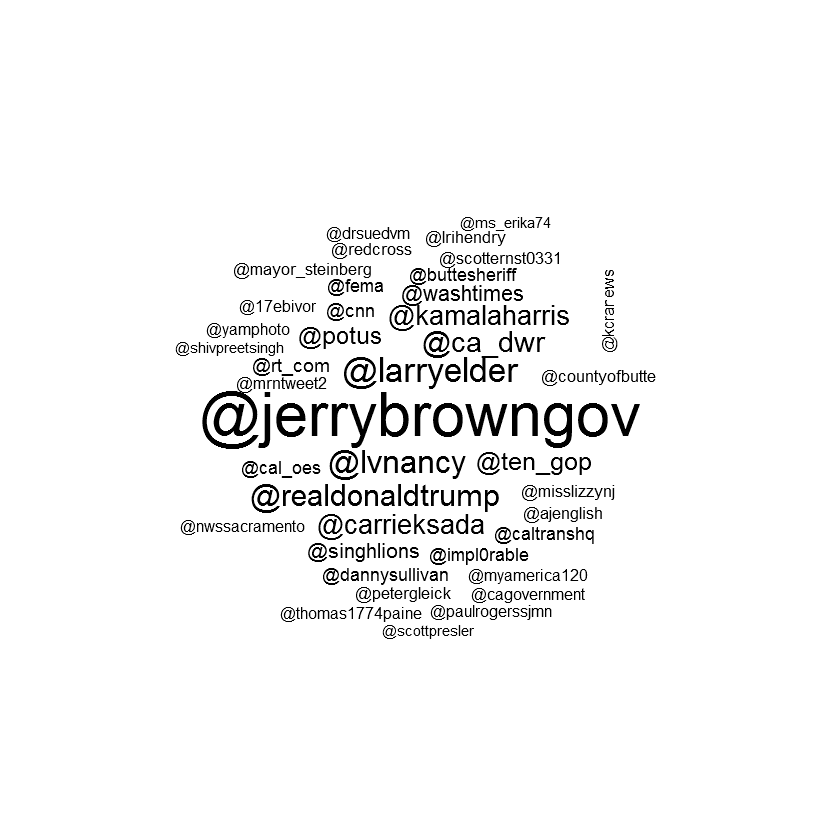

In [25]:
#Wordcloud of most frequent users
set.seed(146)
wordcloud(words = namesCorpus, scale=c(3,0.5), max.words=40, random.order=FALSE, 
          rot.per=0.10, use.r.layout=FALSE)

In [27]:
#label a tweet with the month number
tweets$month=sapply(tweets$timestamp, function(x) {p=as.POSIXlt(x);p$mon})
#label a tweet with the hour
tweets$hour=sapply(tweets$timestamp, function(x) {p=as.POSIXlt(x);p$hour})
#label a tweet with a number corresponding to the day of the week
tweets$wday=sapply(tweets$timestamp, function(x) {p=as.POSIXlt(x);p$wday})

In [21]:
#The xts function creates a timeline from a vector of values and a vector of timestamps.
#If we know how many tweets we have, we can just create a simple list or vector
ts=xts(rep(1,times=nrow(tweets)),tweets$timestamp)
 

In [22]:
#Sum the unit values in daily bin to get a count of the number of tweets per day
ts.sum=apply.daily(ts,sum) 

In [23]:
#Converting Time Series into a dataframe
ts.sum.df=data.frame(date=index(ts.sum), coredata(ts.sum))

In [24]:
colnames(ts.sum.df)=c('date','sum')

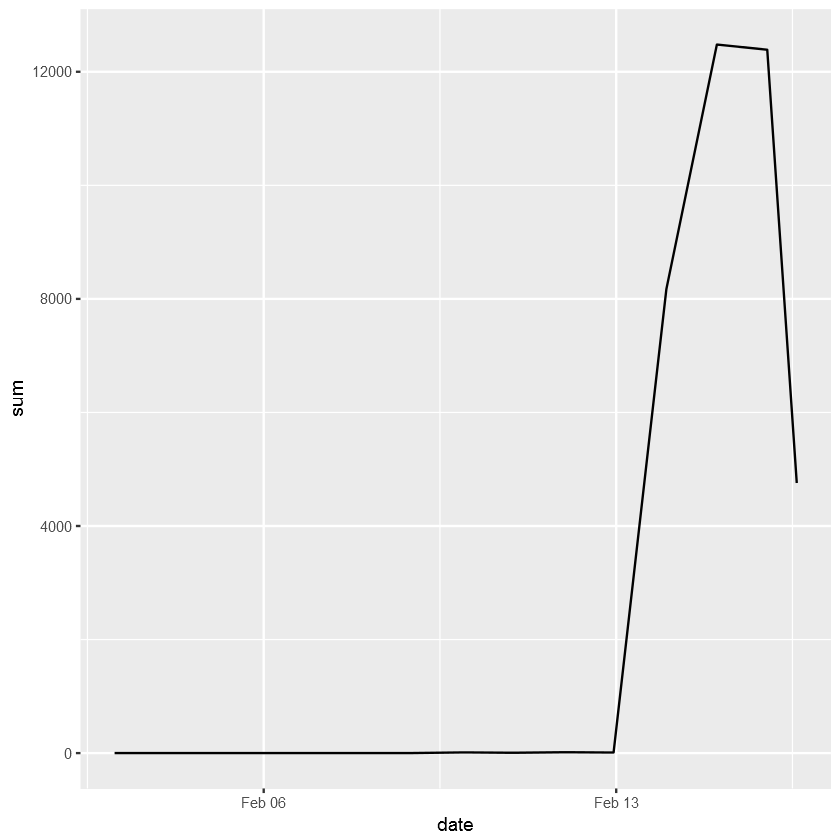

In [25]:
ggplot(ts.sum.df)+geom_line(aes(x=date,y=sum))

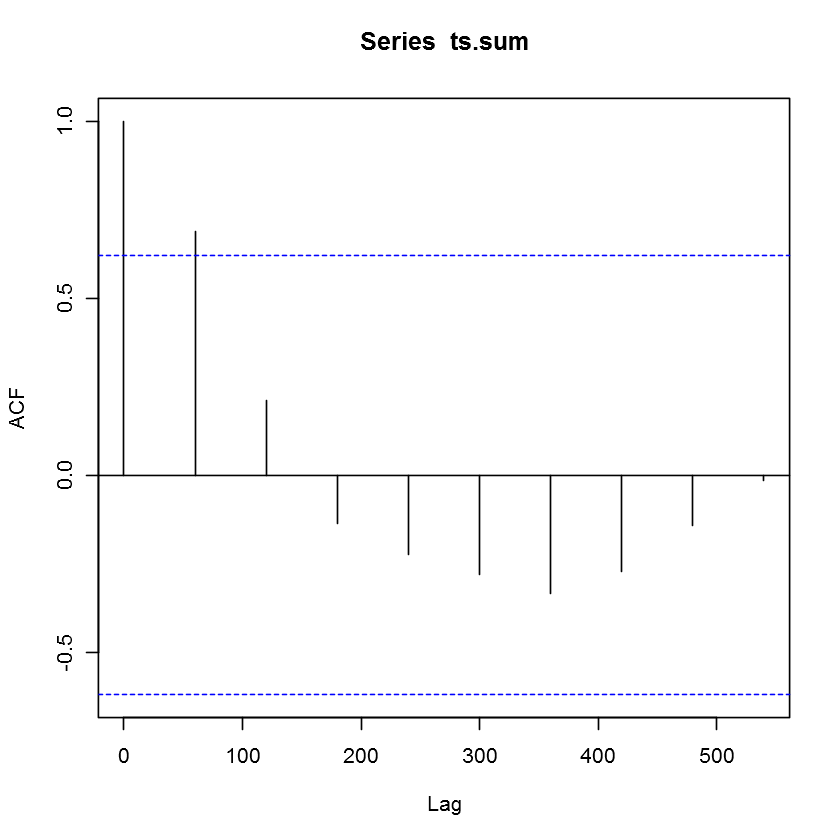

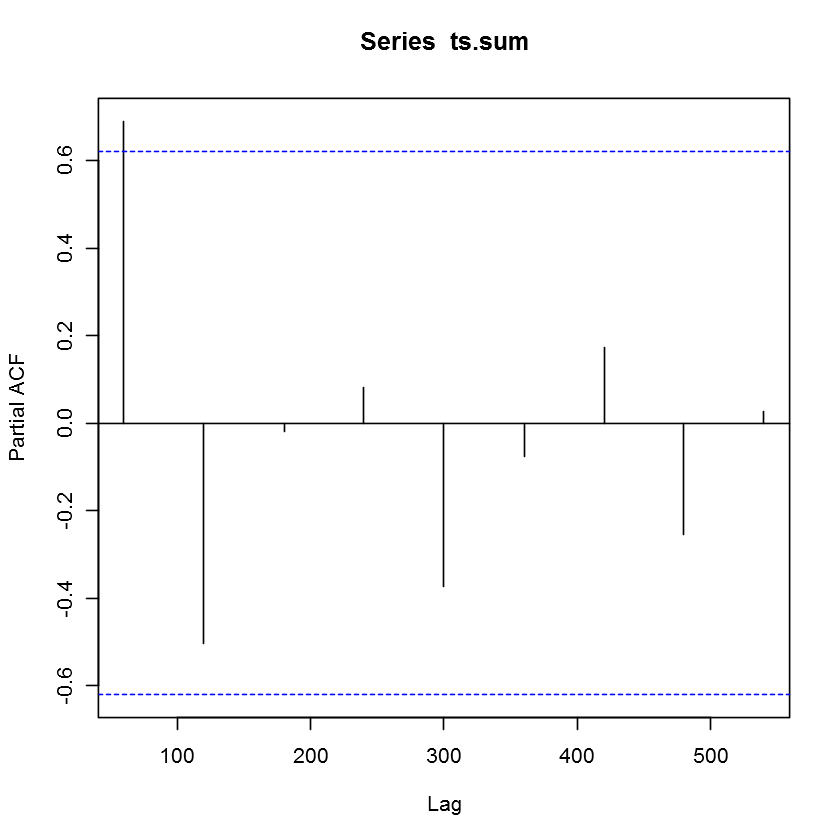

In [28]:
#Having got the data in a timeseries form, we check the autocorrelation:
acf(ts.sum)
pacf(ts.sum)

### The Autocorrelation plot above indicates that the Time-Series is Stationary, as it shows some cyclic behavior as opposed to a Non Stationary Time-Series where there is slow exponential decay. A stationary time series is one that has constant mean and variation over time. It indicates that the user tweet pattern is constant over time, unless there's an incident that might spike up tweets.

In [67]:
#Function to display time-series data as a calendar heatmap 
calendarHeat <- function(dates, 
                         values, 
                         ncolors=99, 
                         color="r2g", 
                         varname="Values",
                         date.form = "%Y-%m-%d", ...) {
require(lattice)
require(grid)
require(chron)
if (class(dates) == "character" | class(dates) == "factor" ) {
  dates <- strptime(dates, date.form)
        }
caldat <- data.frame(value = values, dates = dates)
min.date <- as.Date(paste(format(min(dates), "%Y"),
                    "-1-1",sep = ""))
max.date <- as.Date(paste(format(max(dates), "%Y"),
                     "-12-31", sep = ""))
dates.f <- data.frame(date.seq = seq(min.date, max.date, by="days"))
 
# Merge moves data by one day, avoid
caldat <- data.frame(date.seq = seq(min.date, max.date, by="days"), value = NA)
dates <- as.Date(dates) 
caldat$value[match(dates, caldat$date.seq)] <- values
 
caldat$dotw <- as.numeric(format(caldat$date.seq, "%w"))
caldat$woty <- as.numeric(format(caldat$date.seq, "%U")) + 1
caldat$yr <- as.factor(format(caldat$date.seq, "%Y"))
caldat$month <- as.numeric(format(caldat$date.seq, "%m"))
yrs <- as.character(unique(caldat$yr))
d.loc <- as.numeric()                        
for (m in min(yrs):max(yrs)) {
  d.subset <- which(caldat$yr == m)  
  sub.seq <- seq(1,length(d.subset))
  d.loc <- c(d.loc, sub.seq)
  }  
caldat <- cbind(caldat, seq=d.loc)
 
#color styles
r2b <- c("#0571B0", "#92C5DE", "#F7F7F7", "#F4A582", "#CA0020") #red to blue                                                                               
r2g <- c("#D61818", "#FFAE63", "#FFFFBD", "#B5E384")   #red to green
w2b <- c("#045A8D", "#2B8CBE", "#74A9CF", "#BDC9E1", "#F1EEF6")   #white to blue
             
assign("col.sty", get(color))
calendar.pal <- colorRampPalette((col.sty), space = "Lab")
def.theme <- lattice.getOption("default.theme")
cal.theme <-
   function() {  
  theme <-
  list(
    strip.background = list(col = "transparent"),
    strip.border = list(col = "transparent"),
    axis.line = list(col="transparent"),
    par.strip.text=list(cex=0.8))
    }
lattice.options(default.theme = cal.theme)
yrs <- (unique(caldat$yr))
nyr <- length(yrs)
print(cal.plot <- levelplot(value~woty*dotw | yr, data=caldat,
   as.table=TRUE,
   aspect=.12,
 layout = c(1, nyr%%7),
   between = list(x=0, y=c(1,1)),
   strip=TRUE,
   main = paste("Calendar Heat Map of ", varname, sep = ""),
   scales = list(
     x = list(
               at= c(seq(2.9, 52, by=4.42)),
               labels = month.abb,
               alternating = c(1, rep(0, (nyr-1))),
               tck=0,
               cex = 0.7),
     y=list(
          at = c(0, 1, 2, 3, 4, 5, 6),
          labels = c("Sunday", "Monday", "Tuesday", "Wednesday", "Thursday",
                      "Friday", "Saturday"),
          alternating = 1,
          cex = 0.6,
          tck=0)),
   xlim =c(0.4, 54.6),
   ylim=c(6.6,-0.6),
   cuts= ncolors - 1,
   col.regions = (calendar.pal(ncolors)),
   xlab="" ,
   ylab="",
   colorkey= list(col = calendar.pal(ncolors), width = 0.6, height = 0.5),
   subscripts=TRUE
    ) )
panel.locs <- trellis.currentLayout()
for (row in 1:nrow(panel.locs)) {
    for (column in 1:ncol(panel.locs))  {
    if (panel.locs[row, column] > 0)
{
    trellis.focus("panel", row = row, column = column,
                  highlight = FALSE)
xyetc <- trellis.panelArgs()
subs <- caldat[xyetc$subscripts,]
dates.fsubs <- caldat[caldat$yr == unique(subs$yr),]
y.start <- dates.fsubs$dotw[1]
y.end   <- dates.fsubs$dotw[nrow(dates.fsubs)]
dates.len <- nrow(dates.fsubs)
adj.start <- dates.fsubs$woty[1]
 
for (k in 0:6) {
 if (k < y.start) {
    x.start <- adj.start + 0.5
    } else {
    x.start <- adj.start - 0.5
      }
  if (k > y.end) {
     x.finis <- dates.fsubs$woty[nrow(dates.fsubs)] - 0.5
    } else {
     x.finis <- dates.fsubs$woty[nrow(dates.fsubs)] + 0.5
      }
    grid.lines(x = c(x.start, x.finis), y = c(k -0.5, k - 0.5), 
     default.units = "native", gp=gpar(col = "grey", lwd = 1))
     }
if (adj.start <  2) {
 grid.lines(x = c( 0.5,  0.5), y = c(6.5, y.start-0.5), 
      default.units = "native", gp=gpar(col = "grey", lwd = 1))
 grid.lines(x = c(1.5, 1.5), y = c(6.5, -0.5), default.units = "native",
      gp=gpar(col = "grey", lwd = 1))
 grid.lines(x = c(x.finis, x.finis), 
      y = c(dates.fsubs$dotw[dates.len] -0.5, -0.5), default.units = "native",
      gp=gpar(col = "grey", lwd = 1))
 if (dates.fsubs$dotw[dates.len] != 6) {
 grid.lines(x = c(x.finis + 1, x.finis + 1), 
      y = c(dates.fsubs$dotw[dates.len] -0.5, -0.5), default.units = "native",
      gp=gpar(col = "grey", lwd = 1))
      }
 grid.lines(x = c(x.finis, x.finis), 
      y = c(dates.fsubs$dotw[dates.len] -0.5, -0.5), default.units = "native",
      gp=gpar(col = "grey", lwd = 1))
      }
for (n in 1:51) {
  grid.lines(x = c(n + 1.5, n + 1.5), 
    y = c(-0.5, 6.5), default.units = "native", gp=gpar(col = "grey", lwd = 1))
        }
x.start <- adj.start - 0.5
 
if (y.start > 0) {
  grid.lines(x = c(x.start, x.start + 1),
    y = c(y.start - 0.5, y.start -  0.5), default.units = "native",
    gp=gpar(col = "black", lwd = 1.75))
  grid.lines(x = c(x.start + 1, x.start + 1),
    y = c(y.start - 0.5 , -0.5), default.units = "native",
    gp=gpar(col = "black", lwd = 1.75))
  grid.lines(x = c(x.start, x.start),
    y = c(y.start - 0.5, 6.5), default.units = "native",
    gp=gpar(col = "black", lwd = 1.75))
 if (y.end < 6  ) {
  grid.lines(x = c(x.start + 1, x.finis + 1),
   y = c(-0.5, -0.5), default.units = "native",
   gp=gpar(col = "black", lwd = 1.75))
  grid.lines(x = c(x.start, x.finis),
   y = c(6.5, 6.5), default.units = "native",
   gp=gpar(col = "black", lwd = 1.75))
   } else {
      grid.lines(x = c(x.start + 1, x.finis),
       y = c(-0.5, -0.5), default.units = "native",
       gp=gpar(col = "black", lwd = 1.75))
      grid.lines(x = c(x.start, x.finis),
       y = c(6.5, 6.5), default.units = "native",
       gp=gpar(col = "black", lwd = 1.75))
       }
       } else {
           grid.lines(x = c(x.start, x.start),
            y = c( - 0.5, 6.5), default.units = "native",
            gp=gpar(col = "black", lwd = 1.75))
           }
 
 if (y.start == 0 ) {
  if (y.end < 6  ) {
  grid.lines(x = c(x.start, x.finis + 1),
   y = c(-0.5, -0.5), default.units = "native",
   gp=gpar(col = "black", lwd = 1.75))
  grid.lines(x = c(x.start, x.finis),
   y = c(6.5, 6.5), default.units = "native",
   gp=gpar(col = "black", lwd = 1.75))
   } else {
      grid.lines(x = c(x.start + 1, x.finis),
       y = c(-0.5, -0.5), default.units = "native",
       gp=gpar(col = "black", lwd = 1.75))
      grid.lines(x = c(x.start, x.finis),
       y = c(6.5, 6.5), default.units = "native",
       gp=gpar(col = "black", lwd = 1.75))
       }
       }
for (j in 1:12)  {
   last.month <- max(dates.fsubs$seq[dates.fsubs$month == j])
   x.last.m <- dates.fsubs$woty[last.month] + 0.5
   y.last.m <- dates.fsubs$dotw[last.month] + 0.5
   grid.lines(x = c(x.last.m, x.last.m), y = c(-0.5, y.last.m),
     default.units = "native", gp=gpar(col = "black", lwd = 1.75))
   if ((y.last.m) < 6) {
      grid.lines(x = c(x.last.m, x.last.m - 1), y = c(y.last.m, y.last.m),
       default.units = "native", gp=gpar(col = "black", lwd = 1.75))
     grid.lines(x = c(x.last.m - 1, x.last.m - 1), y = c(y.last.m, 6.5),
       default.units = "native", gp=gpar(col = "black", lwd = 1.75))
   } else {
      grid.lines(x = c(x.last.m, x.last.m), y = c(- 0.5, 6.5),
       default.units = "native", gp=gpar(col = "black", lwd = 1.75))
    }
 }
 }
 }
trellis.unfocus()
} 
lattice.options(default.theme = def.theme)
}

Warning message in if (class(dates) == "character" | class(dates) == "factor") {:
"the condition has length > 1 and only the first element will be used"

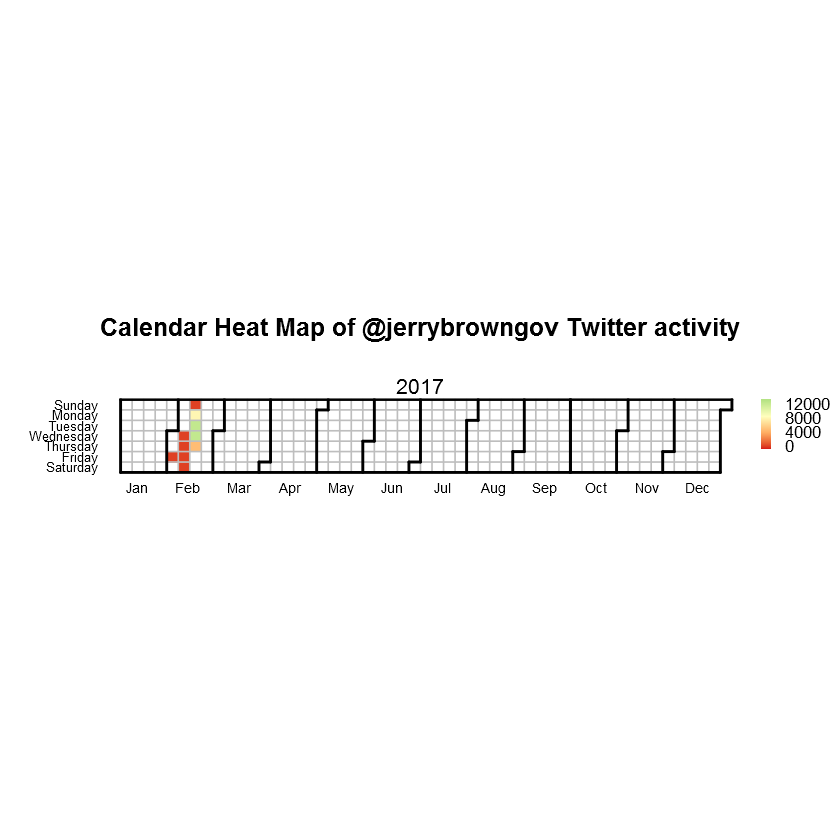

In [74]:
#Generating a heat map of user activity over a period
calendarHeat(ts.sum.df$date, ts.sum.df$sum, varname="@jerrybrowngov Twitter activity")